# Conditional GAN - Testing using Black-Scholes data.

This notebook is a sample of the work done during my thesis project. I use some figures in this notebook in the results section of my MSc. Thesis, specifically Section 5.1, which can be found at the following link: https://github.com/RDS-95/portfolio/blob/main/GANs-MScThesis.pdf

The complete PDF also contains many sources for the information discussed here. 

## Motivation

Asset returns in finance are unpredictable. They are subject to exogenous circumstances such as business news, political events, and pandemics. Even so, when examining returns data statistically, it consistently exhibits the same set of non-trivial properties known in the literature as stylized facts. Collecting all these properties together results in a hugely challenging process to model, to the vexation of many investors, as the pricing of options contracts relies on an accurate way to replicate the behaviour of the underlying asset. Here, as a potential solution to the modelling problem, we turn to the field of deep learning and, in particular, GANs.

## Introduction to GANs

Generative adversarial networks (GANs) undertake a purely data-driven approach to modelling their training sets. It can be summarized as follows: One neural network, the generator, is set up to produce synthetic data. Another neural network, the discriminator, is set up to determine whether the data it receives comes from the real data set or the generator. By pitting these two networks against each other in a zero-sum game, we grow the capability of both, resulting in a generator that can produce outputs mimicking the properties of the training data almost exactly. GANs have shown a remarkable aptitude for modelling complex dependencies in images and videos and have more recently been successfully applied to time series data. Some prominent examples of GANs applied to financial time series are QuantGAN and FIN-GAN, although the architecture used in these GANs is complex and computationally intensive to train. 

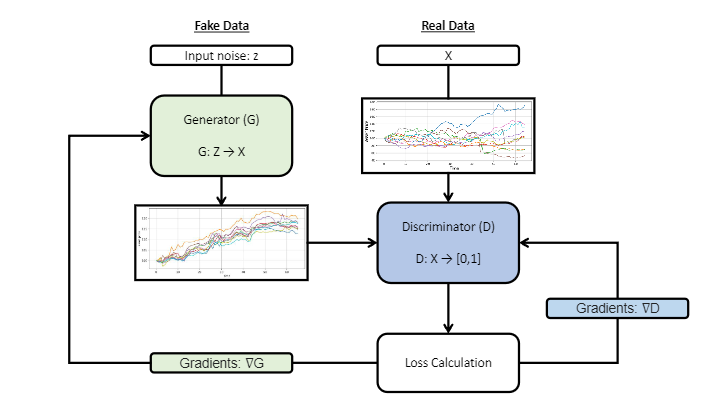

## Conditional Generation

In this notebook, we show that these GANs can be extended to a conditional framework for financial time series. Conditioning allows us to tune model parameters like volatility or interest rate to reflect current market climates. We show that even using (relative to convention) extremely shallow neural networks, the GAN can make inferences about these model parameters and produce statistically appropriate outputs. We first generate data using the Black-Scholes SDE, giving a range of values for the parameter upon which our cGAN will be conditioned. Once the cGAN has been trained, we investigate whether our cGAN has inferred the appropriate effect of each condition by examining its outputs.


In [3]:
import custom_functions

from tensorflow.python.client import device_lib 
import warnings
import statistics

import math
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from pandas_datareader import data
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

from datetime import datetime
from pandas_datareader.data import DataReader
import yfinance as yf

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
import time

import pydot
warnings.filterwarnings("ignore")
     

C:\Users\rudys\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Generating the Training Set

#### Black-Scholes Model

Indisputably the most famous model in financial mathematics, the Black-Scholes model incorporates the idea of geometric Brownian motion to capture the stochastic nature of asset prices. To understand why this makes sense, we can look to the efficient market hypothesis espoused by Malkiel. This theory simply states that the current asset price reflects all past information on the asset. Thus, when considering what the price may be tomorrow, we gain no advantage in looking at the asset price at any other time but today. The Black-Scholes model (along with many other models) reflects this by modeling the asset price $S$ as a Markovian process using the following stochastic differential equation:

$$ dS_t = \mu S_tdt + \sigma S_tdW_t $$

Where $\mu$ is the drift, $\sigma$ is the volatility and $W_t$ is a Wiener process (1-dim Brownian motion here). By applying Ito's Lemma, we get the solution of the SDE as

$$S_t = S_0 \textrm{exp}[(\mu - \frac{1}{2} \sigma ^2)t + \sigma \sqrt{t} Z]$$

Where Z is a standard normal random variable.

In [559]:
S0 = 100 #initial asset price
r = 0.2 #constant short rate

#creating 10 different sigma values
sigmas = [0.001,0.01,0.1,1]

T = 2.0 #time in years

I = 2500 #no. of random draws
M = 64 # highly divisible. Easier to build model with this.
dt = T / M
Sv = np.zeros((len(sigmas), M+1, I))
Sv[:, 0, :] = S0 

#for each sigma, want 1000 processes generated.

for i, sigma in enumerate(sigmas):
    for t in range(1, M+1):
        S_last = Sv[i, t-1]  # Last asset prices
        S_new = S_last * np.exp((r - 0.5*sigma**2) * dt
                                + sigma * np.sqrt(dt) * npr.standard_normal(I))
        Sv[i, t] = S_new

stacked_asset_paths = Sv.reshape((len(sigmas) * I, M+1))

In [560]:
log_returns_array = np.zeros_like(Sv)

for i in range(4):  # i in [0, 4]
    for j in range(2500):  # j in [0, 999]
        for k in range(1, Sv.shape[1]):
            log_returns_array[i, k, j] = np.log(Sv[i, k, j] / Sv[i, k - 1, j])

In [561]:
stacked_logret_paths = log_returns_array.reshape((len(sigmas) * I, M+1))

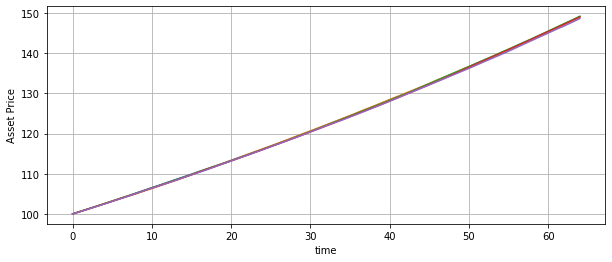

In [566]:
plt.figure(figsize=(10,4))
plt.plot(Sv[0, :, :5], lw=1.5) #y plots of 0.x volatility sim for log_returns_array[x,:,:y]
plt.xlabel("time")
plt.ylabel("Asset Price")
plt.grid(True)

#### Preprocess data for use in the CGAN

Here we attach labels to each of the generated time series. The label is the sigma value which was used to generate that time series.

In [577]:
sigma_values = np.repeat(sigmas, I)
sigma_values = sigma_values[:,None]

In [578]:
stacked_asset_paths = np.reshape(stacked_asset_paths, (-1, 65, 1))
stacked_asset_paths.shape

(10000, 65, 1)

In [579]:
dataset = tf.data.Dataset.from_tensor_slices((stacked_asset_paths, sigma_values))
dataset = dataset.shuffle(buffer_size=10000).batch(32)

#### Building the GAN Model

We strive to make the model as simple as possible here. Since Black-Scholes data is markovian, without any complex dependencies, it stands to reason that we will not need a complex model. We are primarily concerned with demonstrating the conditional learning capabilities of GANs in this notebook, rather than creating the most powerful model.

In [704]:
batch_size = 32
data_dim = 65
noise_dim = 50
data_channels = 1
num_conditions = 1

gen_in_channels = noise_dim + num_conditions 
disc_in_channels = data_channels + num_conditions
  
def make_generator_model():
    
    g_kernel = 5
    gf_dim = 64
    act = layers.ReLU

    model = tf.keras.Sequential()

    model.add(layers.Dense(data_dim * gf_dim, input_shape=(gen_in_channels,)))
    model.add(layers.Reshape((data_dim//1, gf_dim*1)))
    model.add(layers.BatchNormalization())
    
    model.add(act())
    model.add(layers.Conv1DTranspose(data_channels, g_kernel, strides=1, padding='same', activation= 'linear'))
    
    return model

generator = make_generator_model()

In [705]:
generator.summary()

Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 4160)              216320    
                                                                 
 reshape_57 (Reshape)        (None, 65, 64)            0         
                                                                 
 batch_normalization_80 (Bat  (None, 65, 64)           256       
 chNormalization)                                                
                                                                 
 re_lu_63 (ReLU)             (None, 65, 64)            0         
                                                                 
 conv1d_transpose_60 (Conv1D  (None, 65, 1)            321       
 Transpose)                                                      
                                                                 
Total params: 216,897
Trainable params: 216,769
Non-

In [706]:
def make_discriminator_model():
    
    d_kernel = 5
    df_dim = 32

    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(data_dim, disc_in_channels)))
    
    model.add(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1D(df_dim*2, d_kernel, strides=2, padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
        
    model.add(layers.Flatten())
    model.add(layers.Dense(1, use_bias=False))
        
    return model

discriminator = make_discriminator_model()

In [707]:
discriminator.summary()

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 33, 32)            352       
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 33, 32)            0         
                                                                 
 conv1d_58 (Conv1D)          (None, 17, 64)            10304     
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 17, 64)            0         
                                                                 
 flatten_47 (Flatten)        (None, 1088)              0         
                                                                 
 dense_105 (Dense)           (None, 1)                 1088      
                                                                 
Total params: 11,744
Trainable params: 11,744
Non-tr

In [708]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)

In [709]:
@tf.function

def train_step(data):
    
    #Everything between here and the next line below is added as preprocessing for CGAN.
    #-------------------------------------------------------------------------------------
    
    #unpack the sequences and volatilities
    real_series, volatilities = data
    
    #dtype fix.
    real_series = tf.cast(real_series, tf.float32)
    
    # Add dummy dimensions to the labels so that they can be concatenated with
    # the sequences. This is for the discriminator.
    
    series_volatilities = volatilities[:, :, None, None]
    series_volatilities = tf.repeat(
            series_volatilities, repeats=[data_dim]
        )
    series_volatilities = tf.reshape(
            series_volatilities, (-1, data_dim, num_conditions)
        )
    
    #need to concat noise with volatility label for input into generator
    
    batch_size = tf.shape(real_series)[0]
        
    noise = tf.random.normal([batch_size, noise_dim])

    noise_with_labels = tf.concat(
        [noise,  tf.cast(volatilities, dtype=tf.float32)], axis=1
    )
    
    #------------------------------------------------------------------------------------- 
    
    #enter the training step:

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # Decode the noise (guided by labels) to fake series.
        fake_series = generator(noise_with_labels, training=True)
        
        # Combine them with real series. Note that we are concatenating the labels with these series here.
                                
        fake_series_and_labels = tf.concat([fake_series, 
                                            tf.cast(series_volatilities, dtype=tf.float32)], -1)
        
        real_series_and_labels = tf.concat([real_series,
                                            tf.cast(series_volatilities, dtype=tf.float32)], -1)

        real_output = discriminator(real_series_and_labels, training=True)
        fake_output = discriminator(fake_series_and_labels, training=True)

        gen_loss = custom_functions.generator_loss(fake_output)
        disc_loss = custom_functions.discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    
    for epoch in range(epochs):
        start = time.time()

        G_list = []; D_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            G_list.append(gen_loss)
            D_list.append(disc_loss) 

        G_loss.append(np.mean(G_list))
        D_loss.append(np.mean(D_list))

        custom_functions.plot_loss(G_loss, D_loss)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [710]:
train_dataset = dataset

In [711]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 65, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [700]:
num_examples = 10

vol =  np.repeat(1,num_examples).reshape(-1, 1)
noise = np.random.randn(num_examples,noise_dim)
noise_with_vol = np.concatenate((noise, vol), axis=1)

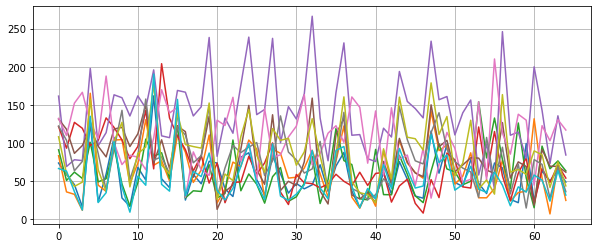

In [701]:
gen_out = generator(noise_with_vol, training=False)
result = tf.squeeze(gen_out)
paths = (result.numpy())

plt.figure(figsize=(10,4))
plt.plot(paths.T)
plt.grid(True)
plt.show()

In [474]:
#Saving the model to rerun later.

model_json = generator.to_json()
with open("Generator_C_BlackScholes64_v3.json", "w") as json_file:
    json_file.write(model_json)
    
generator.save_weights("Generator_C_BlackScholes64_v3.h5")
print("Saved generator to disk")

model_json = discriminator.to_json()
with open("Discriminator_C_BlackScholes64_v3.json", "w") as json_file:
    json_file.write(model_json)
    
discriminator.save_weights("Discriminator_C_BlackScholes64_v3.h5")
print("Saved discriminator to disk")

Saved generator to disk
Saved discriminator to disk


#### Comparison with SDE data.

Here, we compare the distributions of our generated data with the distribution of the GAN output. We can do this for various sigma values.

In [222]:
from keras.models import model_from_json

In [233]:
json_file = open('Generator_BlackScholes64_v8.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
generator = model_from_json(loaded_model_json)
# load weights into new model
generator.load_weights("Generator_BlackScholes64_v8.h5")
print("Loaded model from disk")

Loaded model from disk


In [237]:
noise = np.random.randn(1000,noise_dim)
gen_out = generator(noise, training=False)
result = tf.squeeze(gen_out) 
paths = (result.numpy())

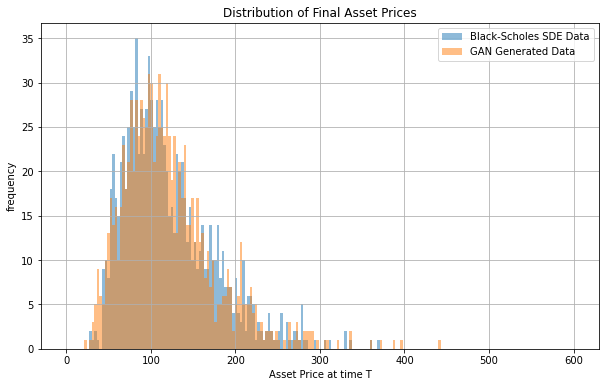

In [238]:
plt.figure(figsize=(10,6))

bins = np.linspace(0, 600,200)
plt.hist(S[-1,:1000], bins=bins, alpha=0.5, label="Black-Scholes SDE Data")
plt.hist(paths[:,-1], bins=bins, alpha=0.5, label="GAN Generated Data")

plt.title("Distribution of Final Asset Prices")

plt.xlabel("Asset Price at time T")
plt.ylabel("frequency")
plt.legend()
plt.grid(True)

plt.show()

#### Kolmogorov-Smirnov Test for two samples.

In [239]:
from scipy.stats import ks_2samp

ks_2samp(S[-1,:1000], paths[:,-1])

KstestResult(statistic=0.029, pvalue=0.7946637387576738)

Using 1000 samples, test result gives p-value >0.05 and we can't reject the null hypothesis that the two populations were drawn from the same distribution.

NB. Could bootstrap this KS test result.

#### Generating Log Returns from GAN data.

In [50]:
GAN_log_returns_array = np.zeros_like(paths.T)
GAN_log_returns_array.shape

(65, 10000)

In [51]:
for j in range(10000):
    for k in range(0, len(paths.T)-1):
        GAN_log_returns_array[k, j] = np.log(paths.T[k, j] / paths.T[k - 1, j])

In [52]:
GAN_log_returns_array = GAN_log_returns_array[1:]
GAN_log_returns_array.shape

(64, 10000)

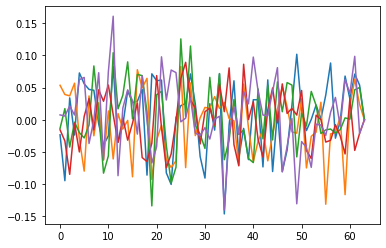

In [95]:
#for log_ret in 
for log_ret in range(5,10):
    plt.plot(GAN_log_returns_array.T[log_ret])

#### Deriving volatility parameter from GAN data

derive the volatility using the fact that $r \sim N(0,\sigma^2)$ which is true for the Black Scholes model.

In [106]:
#create a function to derive the volatility of S given the log returns

def get_vol(log_rets):
    
    mean_log_rets = np.mean(log_rets)
    sq_diff = (log_rets - mean_log_rets) ** 2
    var = np.mean(sq_diff)
    vol = np.sqrt(var)

    return vol

In [134]:
SDE_vols = []
GAN_vols = []

for i in range(0,10000):
    GAN_vols.append(get_vol(GAN_log_returns_array.T[i]))
    SDE_vols.append(get_vol(log_returns_array.T[i]))

volatility_comparison = {'SDE Volatility': np.asarray(SDE_vols), 'GAN Volatility': np.asarray(GAN_vols)}
volatility_comparison_df = pd.DataFrame(volatility_comparison)


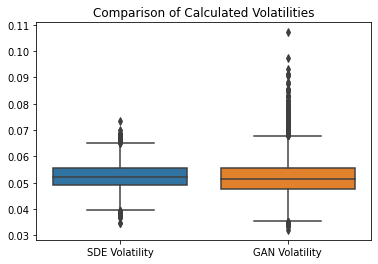

In [141]:
a = sns.boxplot(data = volatility_comparison_df).set(title='Comparison of Calculated Volatilities')

#### Distribution of returns between both methods of generation




In [251]:
flat_GAN_returns = GAN_log_returns_array[:,:1000].flatten()
flat_SDE_returns = log_returns_array[:,:1000].flatten()

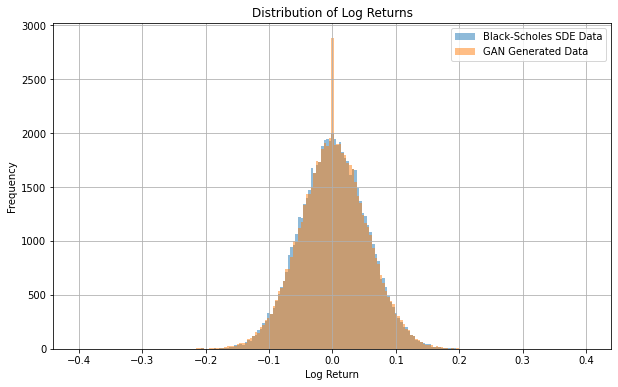

In [256]:
plt.figure(figsize=(10,6))

bins = np.linspace(-0.4, 0.4,200)
plt.hist(flat_SDE_returns, bins=bins, alpha=0.5, label="Black-Scholes SDE Data")
plt.hist(flat_GAN_returns, bins=bins, alpha=0.5, label="GAN Generated Data")

plt.title("Distribution of Log Returns")

plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.show()